<h1>Структура кода обработки датасета</h1>

Для начала инициируем библиотеки, требуемые для анализа: <i>numpy</i> и <i>matplotlib</i>. Получается шаг 0

In [2]:
import numpy as np
import matplotlib.pyplot as plt

<h3>Шаг 1: формирование матрицы из данных</h3>
Для этого используем открытие файла с помощью функции <i>open</i>. Почему не с помощью numpy? Ответ: датасет построен о-о-очень криво, из-за чего присутствуют знаки $, отсутствуют данные и мноооооогое другое. Список полных проблем:
<ul>
<li>Наличие знака "$" в столбце с стоимостью. И то не везде!</li>
<li>Отсутствие цены на марихуану низкого качества начиная с определенной даты</li>
<li>Отсутствие данных за 2 августа в целом. Почему? Неясно</li>
<li>Наличие одной лишней строки в конце файла</li>
<li>Формат оформления элементов - через кавычки. Это создает сложности при переводе в формат <i>float</i>. Придется убирать</li>
</ul>
Возможные вопросы при эксплуатации были прописаны в #-комментариях на английском (потому что комментирование уже началось на английском, а блок текста дописывается на русском! Как-то так)

In [47]:
file = open('data/weeddata2014.csv', encoding='utf-8').readlines()
all_data = [[], [], [], [], [], []]  # according to the index: 0 - high quality price, 1 - high quality count, 2 - medium quality price and so on...
states = []
for i in range(len(file)):
    if i % 52 == 0 and i != len(file) - 1: # have to exclude label data, so doing a check on i % 52 == 0
        for k in range(6):
            all_data[k].append([])
            for _ in range(52):
                all_data[k][-1].append(0) # acc to the index: 0 - day of the year, 1-51 - quantity in states. They are placed in alphabetic order
            all_data[k][-1][0] = i // 52 + 1 + (i // 52 // 213) # i // 52 // 213 part is given to skip 2nd of aug. It is not exist in this dataset
    elif i != len(file) - 1:
        check = file[i].split(',')
        if i // 52 == 0:
            states.append(check[0][1:len(check[0]) - 1])
        for k in (0, 1, 2, 3):
            if k % 2 == 0: # finding lists in 'all_data' with prices
                all_data[k][-1][i % 52] = float(check[k + 1][1 + int('$' in check[k + 1]):len(check[k + 1]) - 1]) # 'int' function in slice was added due to '$'-symbol problem. Check description above the code part
            else:
                all_data[k][-1][i % 52] = int(check[k + 1][1:len(check[k + 1]) - 1])
        if i // 52 < 237:
            all_data[4][-1][i % 52] = float(check[5][1 + int('$' in check[5]):len(check[5]) - 1]) # same as in 21st line 
        if i == len(file) - 1:
            all_data[5][-1][i % 52] = int(check[6][1:len(check[6]) - 1])
        else:
            all_data[5][-1][i % 52] = int(check[6][1:len(check[6]) - 2])


Для удобства переводим полученные данные в матричный формат по переменным. Разделение на них необходимо для дальнейшего анализа без срезов матриц (a.k.a array-ев)

In [43]:
data_hp, data_hn = np.array(all_data[0]), np.array(all_data[1])
data_mp, data_mn = np.array(all_data[2]), np.array(all_data[3])
data_lp, data_ln = np.array(all_data[4][:237]), np.array(all_data[5]) # making a restriction due to not complete data about low quality drug


<h3>Шаг 2: ура, графики!</h3>
Начинаем с построения графика распределения средней цены по штатам! Сделаем это в subplot-ах, которые будут стоять друг под другом (т.к. фиксируется значение по абциссе)

C:\Users\sa1lo\AppData\Local\Temp\ipykernel_33164\1556391675.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels([''] * 52)
C:\Users\sa1lo\AppData\Local\Temp\ipykernel_33164\1556391675.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels([''] * 52)
C:\Users\sa1lo\AppData\Local\Temp\ipykernel_33164\1556391675.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[2].set_xticklabels(states, rotation=90, fontsize=7)


Text(53.972222222222214, 0.5, 'Price, USD')

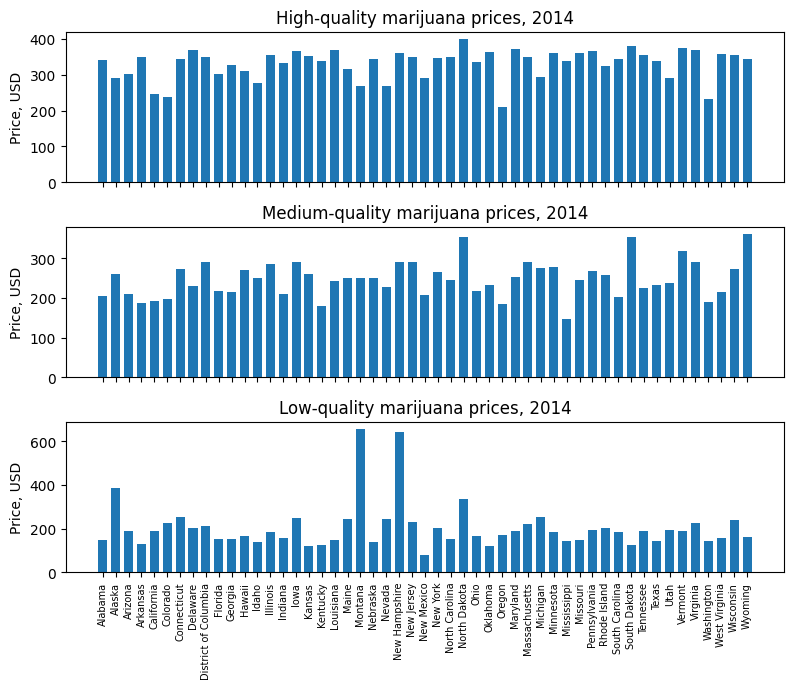

In [48]:
mean_price_hq, mean_price_mq, mean_price_lq = [], [], []
for i in range(1, 52):
    mean_price_hq.append(np.mean(data_hp[:, i]))
    mean_price_mq.append(np.mean(data_mp[:, i]))
    mean_price_lq.append(np.mean(data_lp[:, i]))
fig, ax = plt.subplots(3, 1, figsize=(8, 6))
fig.tight_layout()
ax[0].bar(states, mean_price_hq, 0.7)
ax[0].set_xticklabels([''] * 52)
ax[0].set_title('High-quality marijuana prices, 2014')
ax[0].set_ylabel('Price, USD')
ax[1].bar(states, mean_price_mq, 0.7)
ax[1].set_xticklabels([''] * 52)
ax[1].set_title('Medium-quality marijuana prices, 2014')
ax[1].set_ylabel('Price, USD')
ax[2].bar(states, mean_price_lq, 0.7)
ax[2].set_xticklabels(states, rotation=90, fontsize=7)
ax[2].set_title('Low-quality marijuana prices, 2014')
ax[2].set_ylabel('Price, USD')

Найдем максимальные и минимальные значения цены, получив значение по штатам! Смотрим на максимальные значения и название штата на графике:

In [54]:
print('Highest price of high-quality marijuana (2014) in North Dacota:', str(round(max(mean_price_hq), 2)) + '$')
print('Highest price of med-quality marijuana (2014) in Wyoming:', str(round(max(mean_price_mq), 2)) + '$')
print('Highest price of low-quality marijuana (2014) in Montana:', str(round(max(mean_price_lq), 2)) + '$')

print('Lowest price of high-quality marijuana (2014) in Oregon:', str(round(min(mean_price_hq), 2)) + '$')
print('Lowest price of med-quality marijuana (2014) in Mississipi:', str(round(min(mean_price_mq), 2)) + '$')
print('Lowest price of low-quality marijuana (2014) in New Mexico:', str(round(min(mean_price_hq), 2)) + '$')

Highest price of high-quality marijuana (2014) in North Dacota: 400.84$
Highest price of med-quality marijuana (2014) in Wyoming: 361.9$
Highest price of low-quality marijuana (2014) in Montana: 658.27$
Lowest price of high-quality marijuana (2014) in Oregon: 209.37$
Lowest price of med-quality marijuana (2014) in Mississipi: 147.11$
Lowest price of low-quality marijuana (2014) in New Mexico: 209.37$


А то, если мы хотим сравнить динамику цен? Для этого выведем три графика по порядку: цены на высококачественную марихуану, среднего качества и плохого качества. Для автоматизации покраски используем перевод индекса штата (который мы заранее записали в список <i>state</i>) в цвет. Для хорошего качества это будет <font color="#00FF00">зеленый</font>, для среднего - <font color="#FFFF00">желтый</font>, а для плохого - <font color="#FF0000">красный</font>. Точнее - их оттенки, меняющиеся в зависимости от штата

Text(0.5, 1.0, 'Price of high-quality marijuana in the United States, 2014')

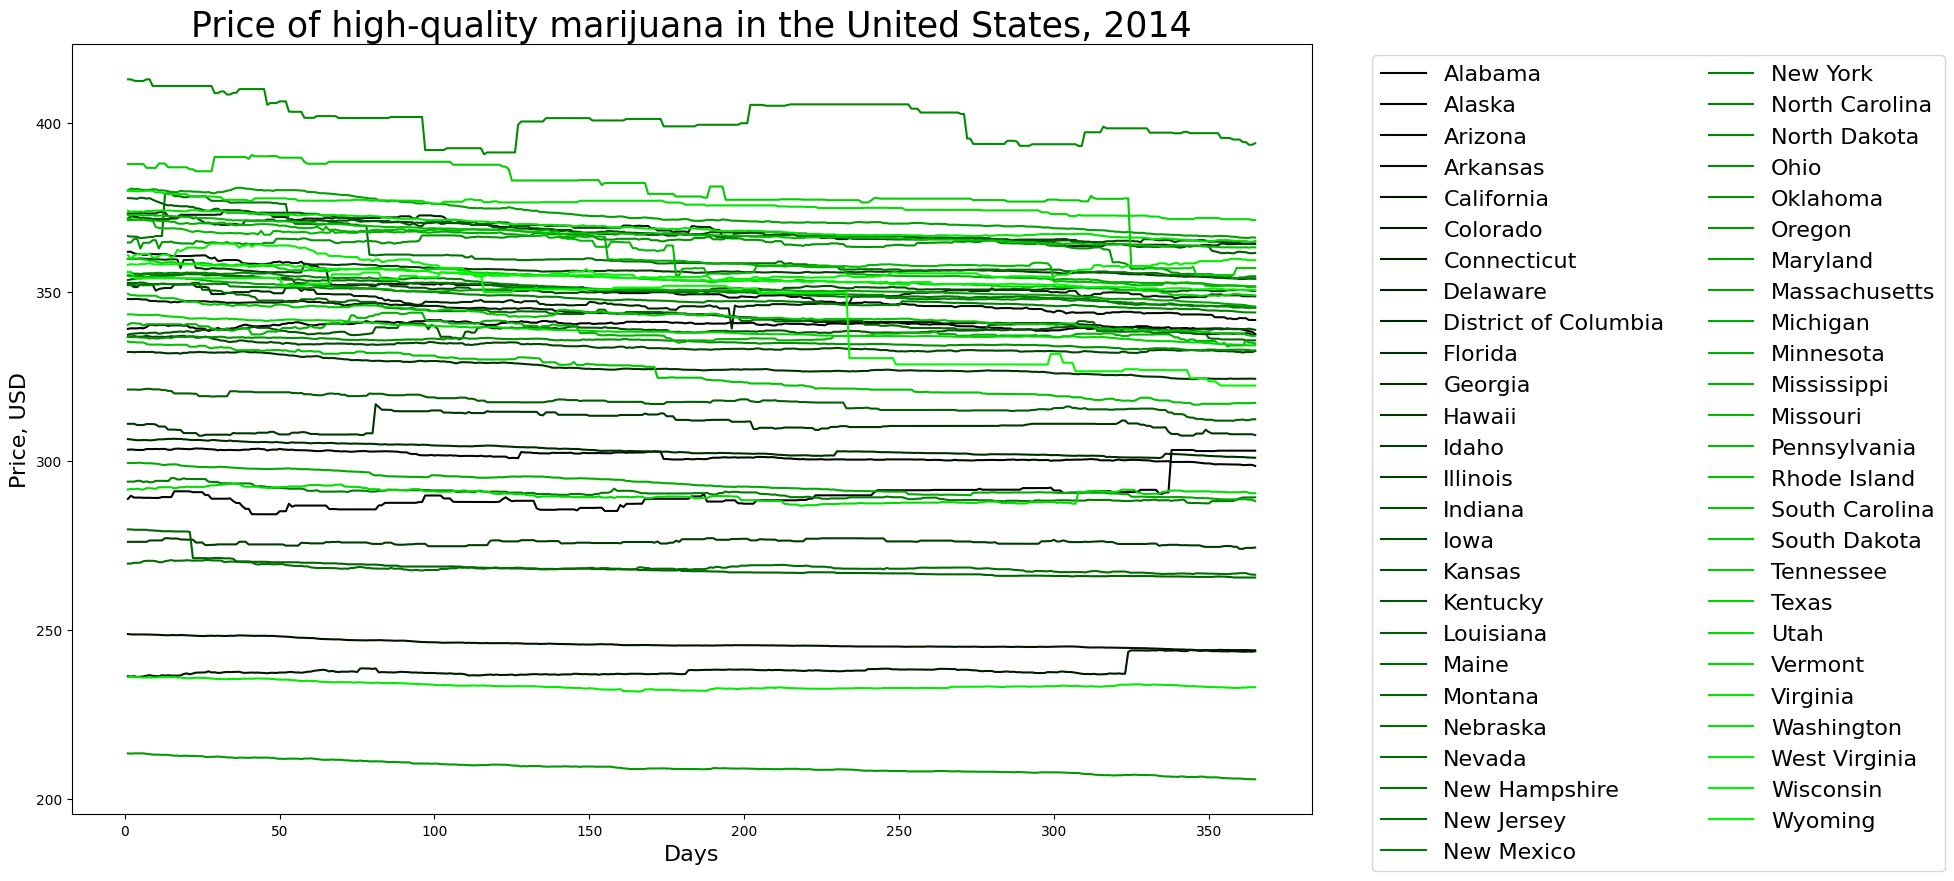

In [9]:
color_scheme = ['00' + '0' * int(len(hex(i)[2:]) == 1) + hex(i)[2:] + '00' for i in range(0, 256, 5)] # hex transformation is used to have html-color palette. int-function usage is similar to step 1
plt.figure(figsize=(16, 10))
for i in range(51):
    plt.plot(data_hp[:, 0], data_hp[:, i + 1], color='#' + color_scheme[i], label=states[i])
plt.xlabel('Days', fontsize=16)
plt.ylabel('Price, USD', fontsize=16)
plt.legend(fontsize=16, ncol=2, bbox_to_anchor=(1.04, 1), loc='upper left')
plt.title('Price of high-quality marijuana in the United States, 2014', fontsize=25)

Text(0.5, 1.0, 'Price of medium-quality marijuana in the United States, 2014')

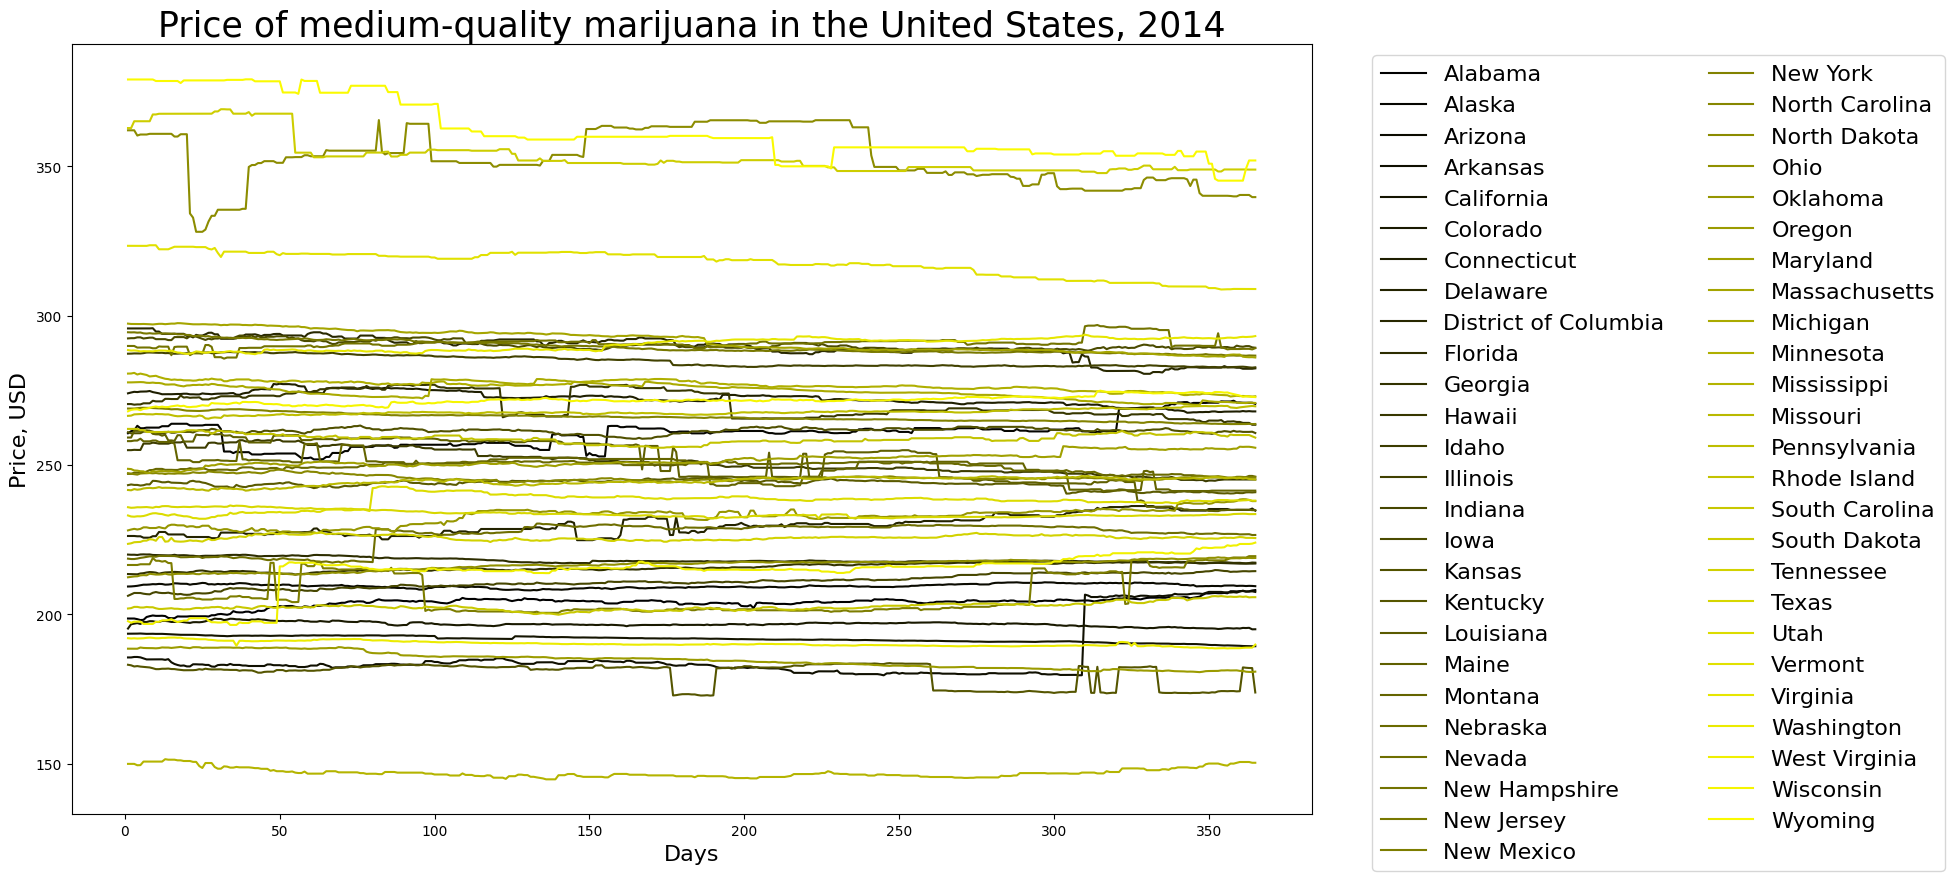

In [10]:
color_scheme = [('0' * int(len(hex(i)[2:]) == 1) + hex(i)[2:]) * 2 + '00' for i in range(0, 256, 5)]
plt.figure(figsize=(16, 10))
for i in range(51):
    plt.plot(data_mp[:, 0], data_mp[:, i + 1], color='#' + color_scheme[i], label=states[i])
plt.xlabel('Days', fontsize=16)
plt.ylabel('Price, USD', fontsize=16)
plt.legend(fontsize=16, ncol=2, bbox_to_anchor=(1.04, 1), loc='upper left')
plt.title('Price of medium-quality marijuana in the United States, 2014', fontsize=25)

Text(0.5, 1.0, 'Price of low-quality marijuana in the United States, 2014')

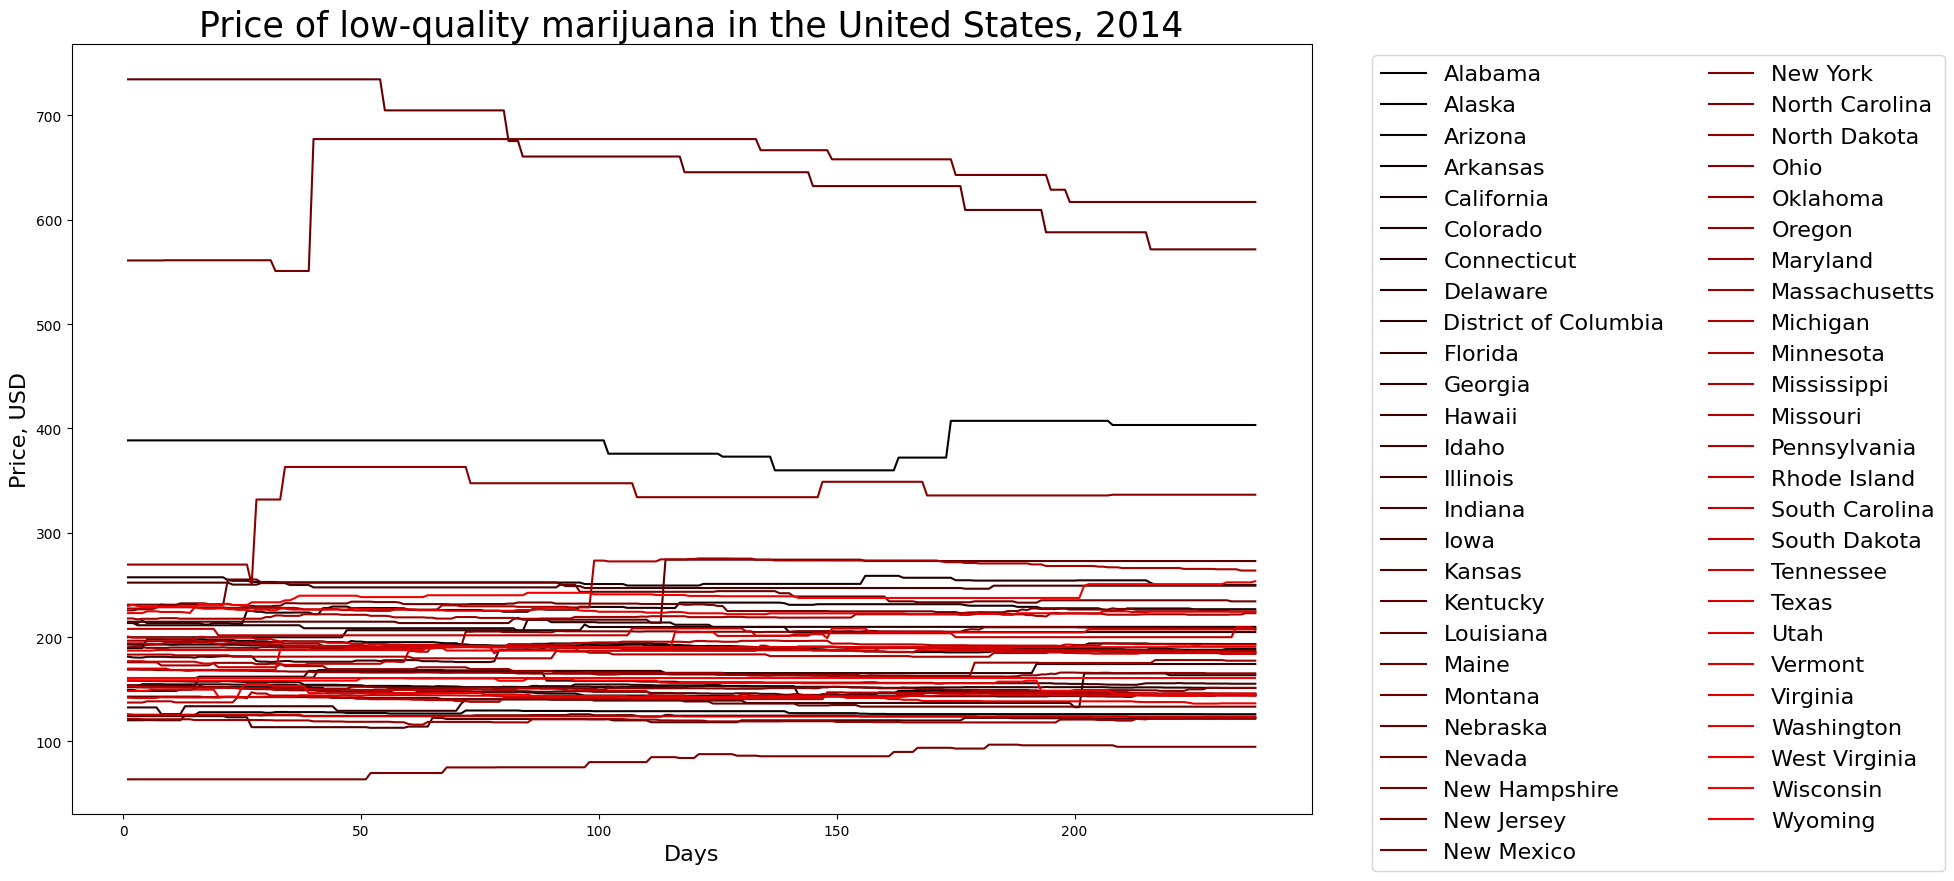

In [11]:
color_scheme = ['0' * int(len(hex(i)[2:]) == 1) + hex(i)[2:] +'0000' for i in range(0, 256, 5)]
plt.figure(figsize=(16, 10))
for i in range(51):
    plt.plot(data_lp[:, 0], data_lp[:, i + 1], color='#' + color_scheme[i], label=states[i])
plt.xlabel('Days', fontsize=16)
plt.ylabel('Price, USD', fontsize=16)
plt.legend(fontsize=16, ncol=2, bbox_to_anchor=(1.04, 1), loc='upper left')
plt.title('Price of low-quality marijuana in the United States, 2014', fontsize=25)

Распределение среднего значения по штатам! Точнее, не среднего, а с учетом весов. В этом помогут столбики с количеством продаваемой марихуаны по штатам и по дням. Можно было сделать с помощью генератора (как и в блоках кода выше), но для более простого понимания использовались обычные циклы for

In [12]:
avr_hq, avr_mq, avr_lq = [], [], []
for i in range(364):
    avr_hq.append([i + 1 + i // 213, (data_hp[i, :][1:] * data_hn[i, :][1:] / np.sum(data_hn[i, :][1:])).sum()])
    avr_mq.append([i + 1 + i // 213, (data_mp[i, :][1:] * data_mn[i, :][1:] / np.sum(data_mn[i, :][1:])).sum()])
for i in range(237):
    avr_lq.append([i + 1 + i // 213, (data_lp[i, :][1:] * data_ln[i, :][1:] / np.sum(data_ln[i, :][1:])).sum()])
avr_hq, avr_mq, avr_lq = np.array(avr_hq), np.array(avr_mq), np.array(avr_lq)

Для иллюстрации строим функцию для получения линейной регрессии

In [13]:
def lin_regression(X):
    k = np.sum((X[:, 0] - X[:, 0].mean()) * (X[:, 1] - X[:, 1].mean())) / np.sum((X[:, 0] - X[:, 0].mean())**2)
    b = X[:, 1].mean() - k * X[:, 0].mean()
    return X[:, 0] * k + b

Комбинируем два блока кода выше в итоговый материал - графики! Сделаем их сабплотами для более удобного сравнения

C:\Users\sa1lo\AppData\Local\Temp\ipykernel_33164\3743957616.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b--" (-> color='b'). The keyword argument will take precedence.
  ax_all[0].plot(avr_hq[:, 0], lin_regression(avr_hq), 'b--', color='#114d1c', label='Trend')
C:\Users\sa1lo\AppData\Local\Temp\ipykernel_33164\3743957616.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b--" (-> color='b'). The keyword argument will take precedence.
  ax_all[1].plot(avr_mq[:, 0], lin_regression(avr_mq), 'b--', color='#4d4f14', label='Trend')
C:\Users\sa1lo\AppData\Local\Temp\ipykernel_33164\3743957616.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b--" (-> color='b'). The keyword argument will take precedence.
  ax_all[2].plot(avr_lq[:, 0], lin_regression(avr_lq), 'b--', color='#981818', label='Trend')


Text(0.5, 0, 'Days')

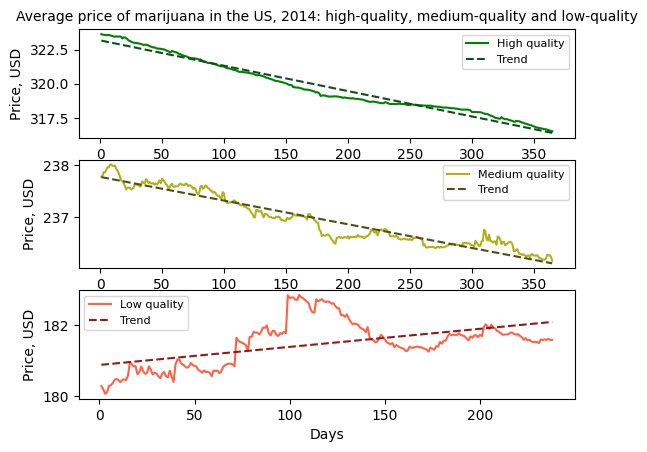

In [14]:
fig_all, ax_all = plt.subplots(3, 1)

ax_all[0].plot(avr_hq[:, 0], avr_hq[:, 1], color='green', label='High quality')
ax_all[0].plot(avr_hq[:, 0], lin_regression(avr_hq), 'b--', color='#114d1c', label='Trend')
ax_all[1].plot(avr_mq[:, 0], avr_mq[:, 1], color='#b1b11c', label='Medium quality')
ax_all[1].plot(avr_mq[:, 0], lin_regression(avr_mq), 'b--', color='#4d4f14', label='Trend')
ax_all[2].plot(avr_lq[:, 0], avr_lq[:, 1], color='tomato', label='Low quality')
ax_all[2].plot(avr_lq[:, 0], lin_regression(avr_lq), 'b--', color='#981818', label='Trend')
for i in range(3):
    ax_all[i].legend(fontsize=8)
    ax_all[i].set_ylabel('Price, USD')
ax_all[0].set_title('Average price of marijuana in the US, 2014: high-quality, medium-quality and low-quality', fontsize=10)
ax_all[2].set_xlabel('Days')

<h3>Шаг 3: анализ по штатам (и округу)</h3>
В 2014 году изменение законодательства в отношении марихуаны коснулось некоторых штатов и округа Колумбия. Начнем с последнего: посмотрим на распределение цены по одному штату за год введения изменения

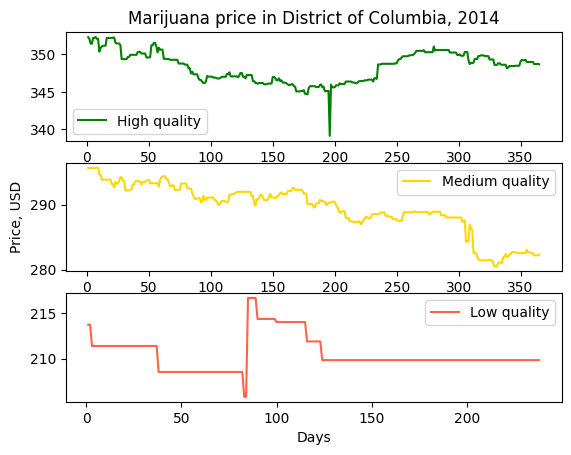

In [42]:
DC_index = states.index('District of Columbia')
fig_dc, ax_dc = plt.subplots(3, 1)
ax_dc[0].plot(data_hp[:, 0], data_hp[:, DC_index + 1], color='green', label='High quality')
ax_dc[0].plot()
ax_dc[1].plot(data_mp[:, 0], data_mp[:, DC_index + 1], color='gold', label='Medium quality')
ax_dc[2].plot(data_lp[:, 0], data_lp[:, DC_index + 1], color='tomato', label='Low quality')
ax_dc[0].set_title('Marijuana price in District of Columbia, 2014')
ax_dc[1].set_ylabel('Price, USD')
ax_dc[2].set_xlabel('Days')
for i in range(3):
    ax_dc[i].legend()

Для дальнейшего анализа возьмем график по цене марихуаны среднего качества. Покажем на графике анологичное качество "товара" в приграничных штатах: Мэриленд и Виргиния. Отобразим и дату принятия изменения - 1 ноября

C:\Users\sa1lo\AppData\Local\Temp\ipykernel_33164\3789619214.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b--" (-> color='b'). The keyword argument will take precedence.
  plt.plot([305, 305], [250, 295], 'b--', color='black', label='1st of November - legalisation date')


Text(0, 0.5, 'Price, USD')

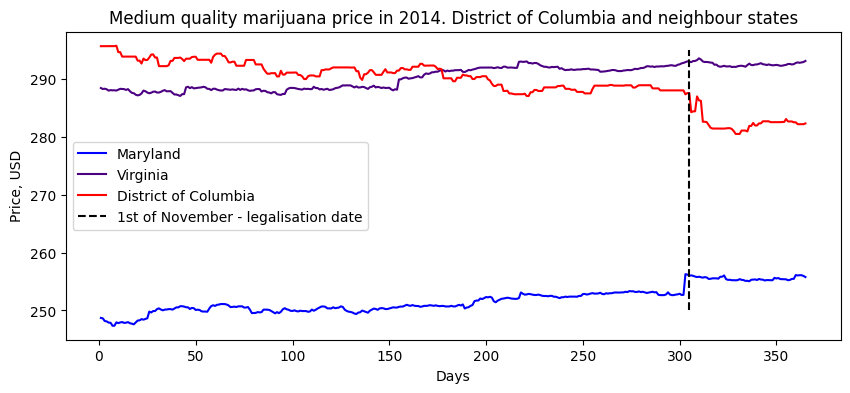

In [50]:
plt.figure(figsize=(10,4))
plt.plot(data_mp[:, 0], data_mp[:, states.index('Maryland') + 1], color='blue', label='Maryland')
plt.plot(data_mp[:, 0], data_mp[:, states.index('Virginia') + 1], color='indigo', label='Virginia')
plt.plot(data_mp[:, 0], data_mp[:, DC_index + 1], color='red', label='District of Columbia')
plt.plot([305, 305], [250, 295], 'b--', color='black', label='1st of November - legalisation date')
plt.legend()
plt.title('Medium quality marijuana price in 2014. District of Columbia and neighbour states')
plt.xlabel('Days')
plt.ylabel('Price, USD')

Посмотрим на эффект легализации марихуаны в другом штате - Нью Йорк. Все аналогично, только не сравнивая с соседями

C:\Users\sa1lo\AppData\Local\Temp\ipykernel_33164\1442027660.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b--" (-> color='b'). The keyword argument will take precedence.
  plt.plot([188, 188], [270, 264], 'b--', color='black', label='7th of July - legalization date')


Text(0.5, 1.0, 'Effect of marijuana legalization in New York state')

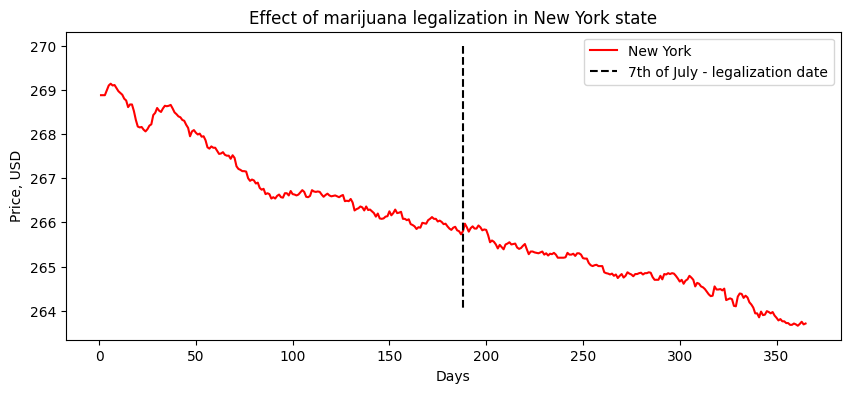

In [39]:
plt.figure(figsize=(10,4))
plt.plot(data_mp[:, 0], data_mp[:, states.index('New York') + 1], color='red', label='New York')
plt.plot([188, 188], [270, 264], 'b--', color='black', label='7th of July - legalization date')
plt.legend()
plt.xlabel('Days')
plt.ylabel('Price, USD')
plt.title('Effect of marijuana legalization in New York state')

А что со штатом Аляска?

C:\Users\sa1lo\AppData\Local\Temp\ipykernel_33164\1126072322.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b--" (-> color='b'). The keyword argument will take precedence.
  plt.plot([308, 308], [270, 250], 'b--', color='black', label='4th of November - legalization date')


Text(0.5, 1.0, 'Effect of marijuana legalization in Alaska state')

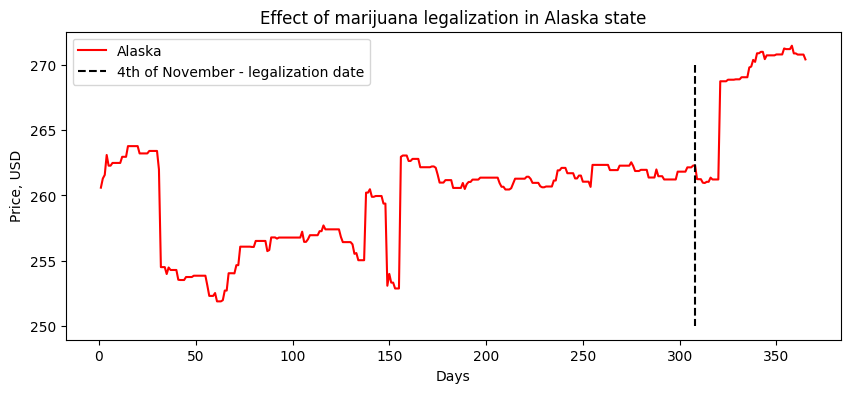

In [40]:
plt.figure(figsize=(10,4))
plt.plot(data_mp[:, 0], data_mp[:, states.index('Alaska') + 1], color='red', label='Alaska')
plt.plot([308, 308], [270, 250], 'b--', color='black', label='4th of November - legalization date')
plt.legend()
plt.xlabel('Days')
plt.ylabel('Price, USD')
plt.title('Effect of marijuana legalization in Alaska state')